https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/historical-volatility-hv/

# Zakelijk inzicht

## Doel
Het doel van deze notebook is om van de CV-waarden van de CAP en EurA1c rapporten te bepalen welke methodes het meest betrouwbaar zijn.

## Situatie
Om dit mogelijk te maken hebben we deze data in een data format nodig die we om kunnen zetten in een Pandas bestand. We beschikken over een Excel bestand, daarmee kan dat.

De CAP en EurA1c data verschilt van elkaar, deze moet apart worden geinterpreteerd

# Data inzicht
Hier lees je inzicht van het data bestand en de data waar in dit notebook mee wordt gewerkt.

## Verzamelen van de data
Het verzamelen van de data komt oorspronkelijk voor door de CAP en EurA1c rapporten om te zetten van PDF bestanden naar één Excel-bestand.

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

df = df = pd.read_excel("Complete-dataset-FINAL.xlsx")
df['Year'] = pd.to_datetime(df["Year"], format='%Y')

cap = df.loc[df['Source (CAP/EurA1c)'] == 'CAP']
eur = df.loc[df['Source (CAP/EurA1c)'] == 'EURA1c']

Na het verzamelen van de data beschikken we over twee datasets. Die van de CAP data en de EurA1c data. Het "df" object bevat beide en gebruiken we om een algemene omschrijving te geven van de data. De reden van twee losse datasets zie je hieronder, de CV-waardes verschillen flink per dataset, vandaar dat ze los gebruikt worden.

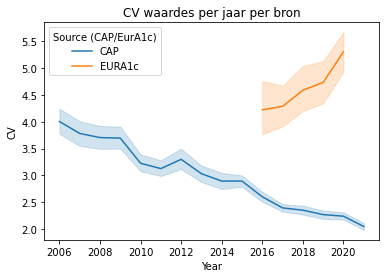

In [130]:
sns.lineplot(x="Year", y="CV", data=df, hue="Source (CAP/EurA1c)")
plt.title("CV waardes per jaar per bron")
plt.show()

# Data voorbereiding
## Selecteren van data
De data die we nodig hebben om de vraag te beantwoorden is een split tussen de Europese en Amerikaanse data. Deze hebben we aan het begin van dit document gemaakt.

Verder hebben we de jaren nodig, gezien we op basis van tijd willen voorspellen.

De CV waarde hebben we nodig gezien we daar naar kijken.

## Data opschonen

In [131]:
print("Aantal Amerikaanse records pre dropna: " + str(len(cap)))
print("Aantal Europese records pre dropna: " + str(len(eur)))

cap.dropna(inplace=True)
eur.dropna(inplace=True)

print("Aantal Amerikaanse records post dropna: " + str(len(cap)))
print("Aantal Europese records post dropna: " + str(len(eur)))

Aantal Amerikaanse records pre dropna: 4170
Aantal Europese records pre dropna: 514
Aantal Amerikaanse records post dropna: 3544
Aantal Europese records post dropna: 514


/var/folders/lt/b2mm13rs6dldsn8kk80k76hh0000gn/T/ipykernel_74980/2475824403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cap.dropna(inplace=True)
/var/folders/lt/b2mm13rs6dldsn8kk80k76hh0000gn/T/ipykernel_74980/2475824403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eur.dropna(inplace=True)


In [132]:
cap_cv = cap[["Year", "Method name", "CV"]].groupby(["Method name", "Year"]).mean()
eur_cv = eur[["Year", "Method name", "CV"]].groupby(["Method name", "Year"]).mean()

Zo te zien worden er bij de Amerikaanse data 100 records uit gegooid met een dropna commando. Die is ervoor om regels met een NaN-waarde te verwijderen.

# Modellering
Om de stabiliteit te modelleren gebruiken we de standaard deviatie.

Als data punten gebruiken we de gemiddelde CV-waarde per jaar per methode. Daarvan nemen we de standaard deviatie. Deze standaard deviatie bepaald de betrouwbaarheid.

# CAP
Hier onder de uitwerking van de betrouwbaarheid voor de CAP CV-waardes

In [133]:
# CAP
df = cap_cv.copy()

# Haal elke methode op die in de cap data aanwezig is
# Wordt een lijst []
methods = cap_cv.index.get_level_values(0).unique()

# Maak een lege dataset aan die we gaan vullen
volatility = pd.DataFrame(columns=["Method", "Volatility", "Data points amount"])

# Minimum van de data points om een vertekend beeld te voorkomen
minYears = 5

# Ga door alle methodes heen
for method in methods:
    # Als de methode minder data punten bevat dan het minimum, dan wordt deze methode overgeslagen
    if len(df.loc[method]) < minYears:
        continue
    # Haal de CV waardes per jaar op van de methode
    cvs = df.loc[method]

    # Bereken de betrouwbaarheid van de CV waarde per jaar
    variance = cvs.std(ddof=0)[0]

    # Voeg de methode toe aan de betrouwbaarheid dataset
    volatility = pd.concat([volatility, pd.DataFrame({"Method": [method], "Volatility": [variance]})])

# Sorteer de dataset op betrouwbaarheid
volatility.sort_values(by=["Volatility"], inplace=True)
volatility.reset_index(drop=True, inplace=True)
volatility.set_index("Method", inplace=True)

# Voeg aan de betrouwbaarheid dataset het aantal data punten toe
for method in methods:
    volatility.loc[method, "Data points amount"] = len(df.loc[method])

# Loop waarmee je classes toevoegd aan de betrouwbaarheid dataset
classes = []
count = 0
while count < len(volatility):
    classes.append(int(count/5) + 1)
    count += 1
volatility["Class"] = classes
volatility.dropna(inplace=True)
volatility["Volatility"] = volatility["Volatility"].astype(float)
volatility["Data points amount"] = volatility["Data points amount"].astype(int)

volatility.head(20)

,Volatility,Data points amount,Class
Method,,,
Sebia Capillarys 2 Flex Piercing,0.062921,5,1
Roche Diagnostics Cobas c513,0.093631,5,1
Bio-Rad D-100,0.121189,5,1
Tosoh G8 Auto HPLC,0.133672,13,1
Bio-Rad Variant II Turbo,0.143534,11,1
Arkray Adams HA-8180 series,0.151069,6,2
Siemens DCA Vantage,0.156433,13,2
Vitros 5.1 FS. 4600. 5600,0.163658,10,2
Roche Diagnostics Cobas c500 series,0.193586,9,2


Hierboven zie je de top 20 meest betrouwbare methodes van de CAP rapporten.

"Data points amount" geeft het aantal gebruikte data punten aan
"Class" geeft aan in welke klasse deze thuis hoort. Klasse 1 zijn de meest betrouwbare methodes.

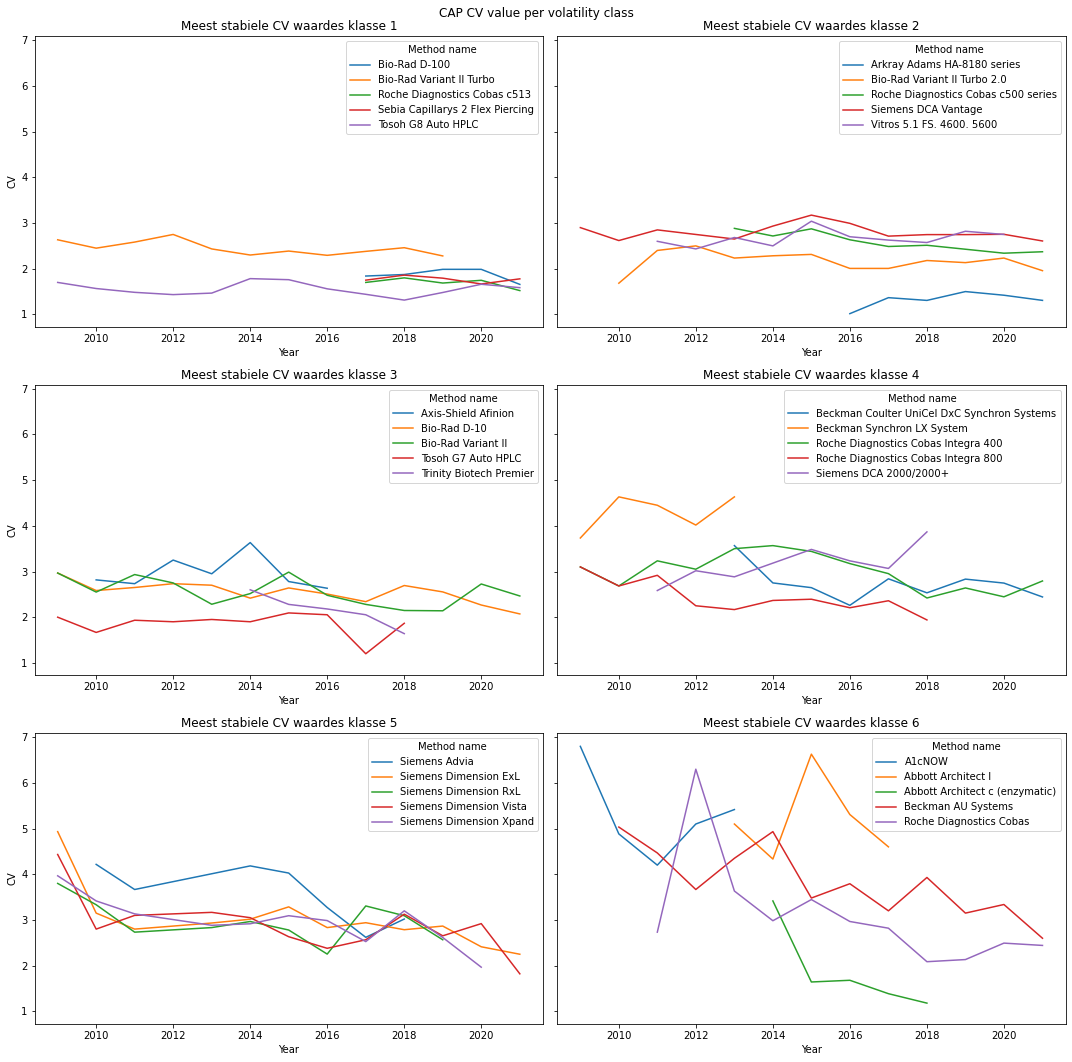

In [134]:
import numpy as np
from math import ceil, floor

# Maak in de algemene dataset een kolom aan met de klassen
df_cap = df.copy()
df_cap["Class"] = np.nan

# Match de klassen aan de klassen in de betrouwbaarheid dataset en vul de algemene dataset daarmee
for method in volatility.index:
    df_cap.loc[method, "Class"] = volatility.loc[method, "Class"]

# Wat plot magie
# Aantal klassen
class_amount = int(df_cap["Class"].max())

# Hoeveel rijen er nodig zijn
columns = ceil(class_amount / 5)

# Hoeveel kolommen er nodig zijn
rows = ceil(class_amount / 2) - 1

# Maak een figuur aan met de juiste grootte en aantal rijen en kolommen
# Zorg dat de Y-as wordt gedeeld, zodat de verschillen duidelijker te zien zijn
fig, axes = plt.subplots(rows, columns, figsize=(15, 15), sharey=True, squeeze=False)

# Geef een titel aan het figuur
fig.suptitle("CAP CV value per volatility class")

# Plot elke klasse op de juiste plaats
for i in range(1, class_amount):
    # Selecteer de datapunten van de klasse
    selection = df_cap.loc[df_cap["Class"] == i]
    
    # Bepaal de X en Y (in welke grafiek en welke kolom deze klasse moet komen)
    x = (i - 1) % columns
    y = floor((i - 1) / columns)

    # Zet de juiste titel bij de juiste grafiek
    axes[y, x].set_title(f"Meest stabiele CV waardes klasse {i}")
    
    # Plot de data punten van de klassen in de juiste grafiek
    sns.lineplot(ax=axes[y, x], data=selection, x="Year", y="CV", hue="Method name")
fig.tight_layout()
plt.show()

Deze visualisaties is een visuele varificatie van de klasses. Zo is te zien dat klasse 1 erg stabiel is en dat per klasse de lijnen steeds instabieler worden.

# EurA1c
Hier onder de uitwerking van de betrouwbaarheid voor de EurA1c CV-waardes

In [139]:
# EurA1c
df = eur_cv.copy()

# Haal elke methode op die in de EurA1c data aanwezig is
# Wordt een lijst []
methods = eur_cv.index.get_level_values(0).unique()

# Maak een lege dataset aan die we gaan vullen
volatility = pd.DataFrame(columns=["Method", "Volatility", "Data points amount"])

# Minimum van de data points om een vertekend beeld te voorkomen
minYears = 3

# Ga door alle methodes heen
for method in methods:
    # Als de methode minder data punten bevat dan het minimum, dan wordt deze methode overgeslagen
    if len(df.loc[method]) < minYears:
        continue
    # Haal de CV waardes per jaar op van de methode
    cvs = df.loc[method]

    # Bereken de betrouwbaarheid van de CV waarde per jaar
    variance = cvs.std(ddof=0)[0]

    # Voeg de methode toe aan de betrouwbaarheid dataset
    volatility = pd.concat([volatility, pd.DataFrame({"Method": [method], "Volatility": [variance]})])

# Sorteer de dataset op betrouwbaarheid
volatility.sort_values(by=["Volatility"], inplace=True)
volatility.reset_index(drop=True, inplace=True)
volatility.set_index("Method", inplace=True)

# Voeg aan de betrouwbaarheid dataset het aantal data punten toe
for method in methods:
    volatility.loc[method, "Data points amount"] = len(df.loc[method])

# Loop waarmee je classes toevoegd aan de betrouwbaarheid dataset
classes = []
count = 0
while count < len(volatility):
    classes.append(int(count/5) + 1)
    count += 1
volatility["Class"] = classes
volatility.dropna(inplace=True)
volatility["Volatility"] = volatility["Volatility"].astype(float)
volatility["Data points amount"] = volatility["Data points amount"].astype(int)

volatility.head(20)

,Volatility,Data points amount,Class
Method,,,
Bio-Rad not specified/other,0.108012,3,1
Tosoh not specified/other,0.131233,3,1
Roche Diagnostics,0.173606,3,1
Menarini (ARKRAY) not specified/other,0.251558,4,1
Tosoh G8 Auto HPLC,0.257196,5,1
Bio-Rad D-10,0.279106,5,2
Tosoh G11 Auto HPLC,0.330614,3,2
Alere Afinion,0.374700,5,2
Bio-Rad D-100,0.465994,5,2


Hierboven zie je de top 20 meest betrouwbare methodes van de CAP rapporten.

"Data points amount" geeft het aantal gebruikte data punten aan
"Class" geeft aan in welke klasse deze thuis hoort. Klasse 1 zijn de meest betrouwbare methodes.

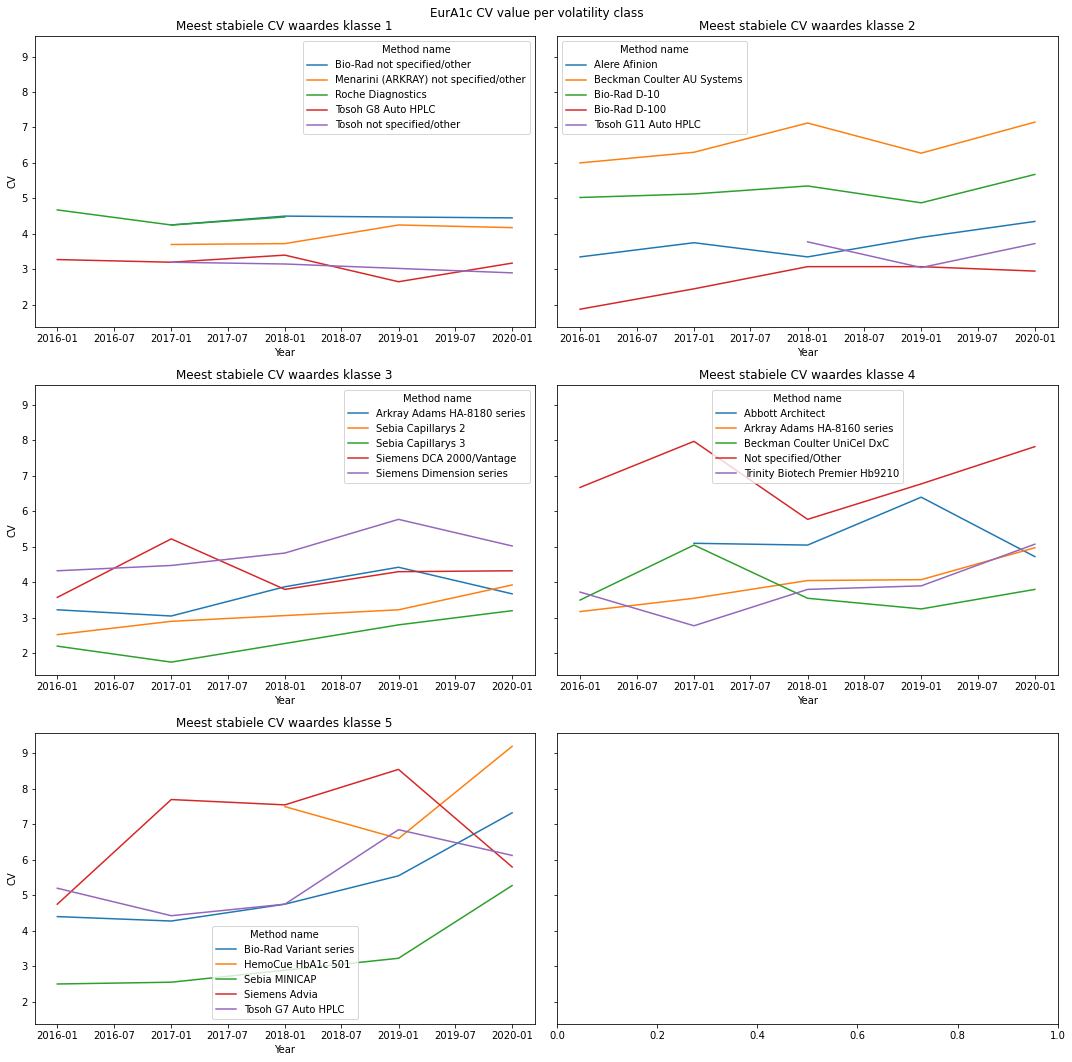

In [141]:
import numpy as np
from math import ceil, floor

# Maak in de algemene dataset een kolom aan met de klassen
df_cap = df.copy()
df_cap["Class"] = np.nan

# Match de klassen aan de klassen in de betrouwbaarheid dataset en vul de algemene dataset daarmee
for method in volatility.index:
    df_cap.loc[method, "Class"] = volatility.loc[method, "Class"]

# Wat plot magie
# Aantal klassen
class_amount = int(df_cap["Class"].max())

# Hoeveel rijen er nodig zijn
columns = ceil(class_amount / 5)

# Hoeveel kolommen er nodig zijn
rows = ceil(class_amount / 2)

# Maak een figuur aan met de juiste grootte en aantal rijen en kolommen
# Zorg dat de Y-as wordt gedeeld, zodat de verschillen duidelijker te zien zijn
fig, axes = plt.subplots(rows, columns, figsize=(15, 15), sharey=True, squeeze=False)

# Geef een titel aan het figuur
fig.suptitle("EurA1c CV value per volatility class")

# Plot elke klasse op de juiste plaats
for i in range(1, class_amount):
    # Selecteer de datapunten van de klasse
    selection = df_cap.loc[df_cap["Class"] == i]
    
    # Bepaal de X en Y (in welke grafiek en welke kolom deze klasse moet komen)
    x = (i - 1) % columns
    y = floor((i - 1) / columns)

    # Zet de juiste titel bij de juiste grafiek
    axes[y, x].set_title(f"Meest stabiele CV waardes klasse {i}")
    
    # Plot de data punten van de klassen in de juiste grafiek
    sns.lineplot(ax=axes[y, x], data=selection, x="Year", y="CV", hue="Method name")
fig.tight_layout()
plt.show()

Deze visualisaties is een visuele varificatie van de klasses. Zo is te zien dat klasse 1 erg stabiel is en dat per klasse de lijnen steeds instabieler worden.

# Evaluatie
De tabellen geven een overzicht van de standaard deviatie. Van de verdeling in klasses zijn de grafieken te zien.

Wat ter discussie staat is of de standaard deviatie de juiste tool is om de betrouwbaarheid te bepalen. Volgens dit artikel: https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/historical-volatility-hv/ is dat het geval.

Deze grafieken en tabellen geven inzicht in de stabiliteit en daarmee is het beoogde doel bereikt.